In [ ]:
!pip install scikit-image
!pip install matplotlib
!pip install numpy

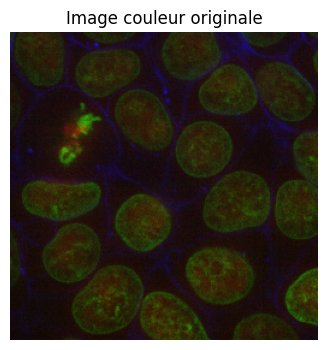

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import cells3d as c3d
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage import morphology
from scipy import ndimage as ndi
from skimage.measure import regionprops
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import measure

# ========================================
# 1. CONSTRUCTION DE L'IMAGE COULEUR
# ========================================
cell_img = np.stack((c3d()[20,1], c3d()[36,1]/2, c3d()[30,0]), axis=2)
cell_img_normalized = cell_img / cell_img.max()

plt.figure(figsize=(4, 4))
plt.imshow(cell_img_normalized)
plt.title("Image couleur originale")
plt.axis('off')
plt.show()

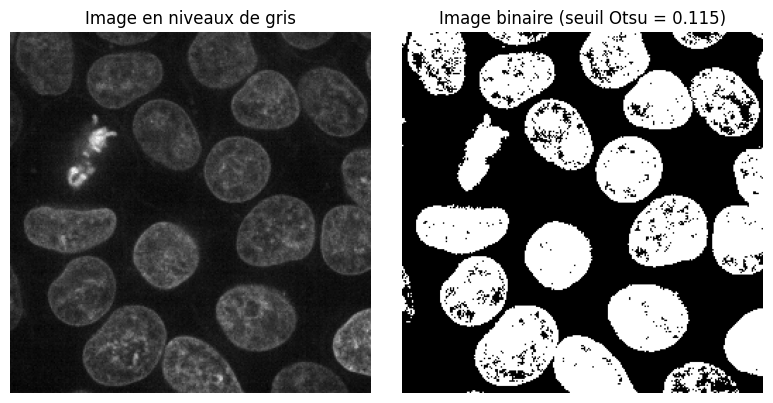

In [2]:
# ========================================
# 2. SEUILLAGE D'OTSU
# ========================================
# Convertir en niveaux de gris
gray_img = rgb2gray(cell_img_normalized)

# Calcul du seuil d'Otsu
seuil_otsu = threshold_otsu(gray_img)

# Image binaire après seuillage Otsu
img_binaire_otsu = gray_img > seuil_otsu

# Affichage
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title("Image en niveaux de gris")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_binaire_otsu, cmap='gray')
plt.title(f"Image binaire (seuil Otsu = {seuil_otsu:.3f})")
plt.axis('off')

plt.tight_layout()
plt.show()

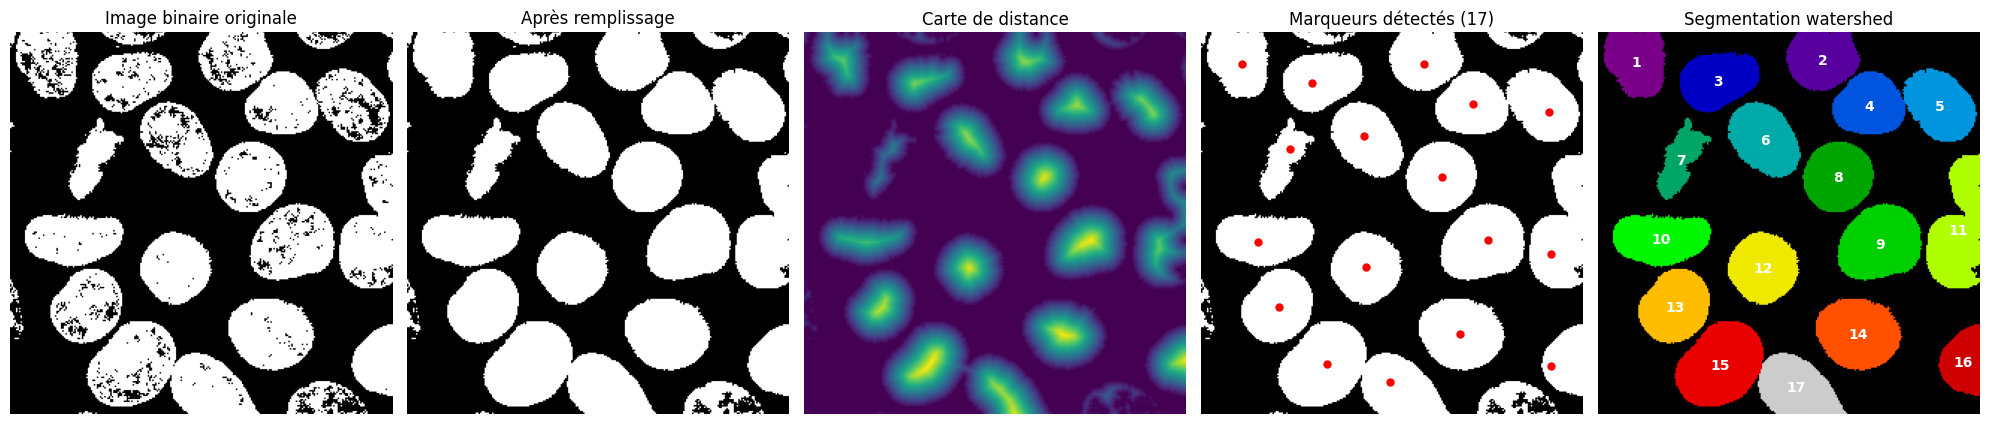

In [5]:
# ========================================
# 3. SÉPARATION DES CELLULES PAR WATERSHED
# ========================================

# Étape 1: Remplissage des trous
img_fill = ndi.binary_fill_holes(img_binaire_otsu)

# Étape 2: Calcul de la carte de distance
distance = ndi.distance_transform_edt(img_fill)

# Étape 3: Détection des maxima locaux (centres des cellules)
coords = peak_local_max(distance, min_distance=21, labels=img_fill)

# Créer un masque des marqueurs
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True

# Étiqueter les marqueurs
markers, _ = ndi.label(mask)

# Étape 4: Application du watershed
labels = watershed(-distance, markers, mask=img_fill)

# Supprimer les petits objets
min_size = 500
labels = morphology.remove_small_objects(labels, min_size=min_size)

# Affichage des résultats du watershed
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.imshow(img_binaire_otsu, cmap='gray')
plt.title("Image binaire originale")
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(img_fill, cmap='gray')
plt.title("Après remplissage")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(distance, cmap='viridis')
plt.title("Carte de distance")
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(img_fill, cmap='gray')
plt.plot(coords[:, 1], coords[:, 0], 'r.', markersize=10)
plt.title(f"Marqueurs détectés ({len(coords)})")
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(labels, cmap='nipy_spectral')
plt.title("Segmentation watershed")
plt.axis('off')

regions = regionprops(labels)
for idx, region in enumerate(regions, start=1):
    y, x = region.centroid
    plt.text(x, y, str(idx), color='white', fontsize=10,
             weight='bold', ha='center', va='center')

plt.tight_layout()
plt.show()

Nombre de cellules détectées : 17

--- Statistiques des cellules ---
Cellule 1: taille=1520.0 pixels, R=0.148, G=0.135, B=0.039
Cellule 2: taille=1599.0 pixels, R=0.153, G=0.143, B=0.056
Cellule 3: taille=1620.0 pixels, R=0.158, G=0.148, B=0.045
Cellule 4: taille=1592.0 pixels, R=0.158, G=0.168, B=0.050
Cellule 5: taille=1729.0 pixels, R=0.146, G=0.138, B=0.055
Cellule 6: taille=1761.0 pixels, R=0.166, G=0.139, B=0.039
Cellule 7: taille=900.0 pixels, R=0.230, G=0.257, B=0.038
Cellule 8: taille=1755.0 pixels, R=0.161, G=0.161, B=0.041
Cellule 9: taille=2250.0 pixels, R=0.154, G=0.164, B=0.032
Cellule 10: taille=1796.0 pixels, R=0.168, G=0.185, B=0.038
Cellule 11: taille=2249.0 pixels, R=0.154, G=0.170, B=0.035
Cellule 12: taille=1734.0 pixels, R=0.180, G=0.192, B=0.035
Cellule 13: taille=1811.0 pixels, R=0.160, G=0.151, B=0.030
Cellule 14: taille=2131.0 pixels, R=0.189, G=0.178, B=0.024
Cellule 15: taille=2527.0 pixels, R=0.166, G=0.162, B=0.023
Cellule 16: taille=995.0 pixels, R=0.186,

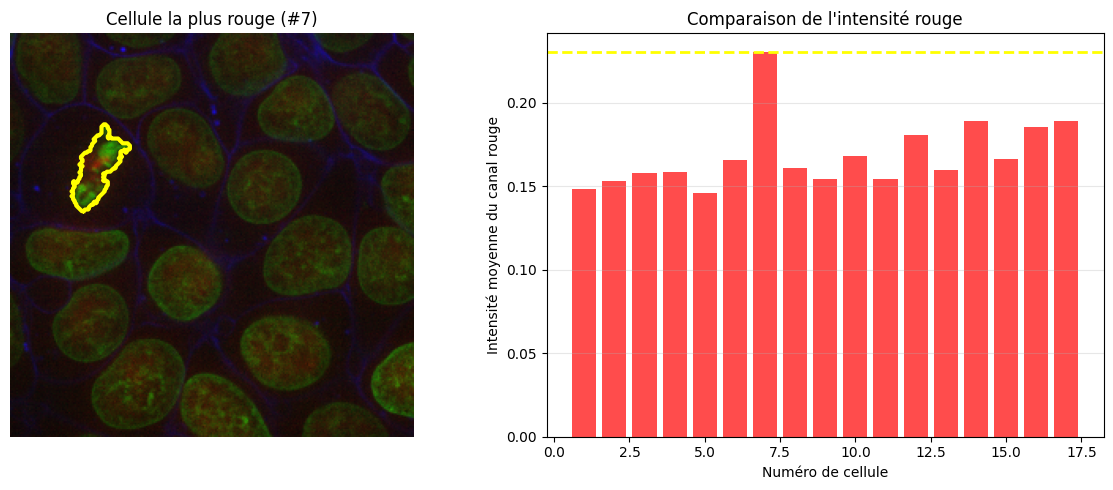

In [6]:
# ========================================
# 4. ANALYSE DES CELLULES
# ========================================

# Nombre de cellules détectées
nb_cellules = len(regions)
print("Nombre de cellules détectées :", nb_cellules)

tailles = []
moyennes_R = []
moyennes_G = []
moyennes_B = []

for region in regions:
    # Taille (aire en pixels)
    taille = region.area
    tailles.append(taille)

    # Masque de la cellule
    mask_cellule = labels == region.label

    # Récupérer les valeurs RGB de cette cellule
    R = cell_img_normalized[:,:,0][mask_cellule]
    G = cell_img_normalized[:,:,1][mask_cellule]
    B = cell_img_normalized[:,:,2][mask_cellule]

    # Calcul des moyennes
    moyennes_R.append(np.mean(R))
    moyennes_G.append(np.mean(G))
    moyennes_B.append(np.mean(B))

# ------------------------------
# Affichage des résultats
# ------------------------------

print("\n--- Statistiques des cellules ---")
for i in range(nb_cellules):
    print(f"Cellule {i+1}: taille={tailles[i]} pixels, "
          f"R={moyennes_R[i]:.3f}, G={moyennes_G[i]:.3f}, B={moyennes_B[i]:.3f}")

# ------------------------------
# Trouver la cellule la plus "rouge"
# ------------------------------
index_rouge = np.argmax(moyennes_R)
print(f"\nLa cellule la plus rouge est la cellule {index_rouge+1} "
      f"(moyenne R = {moyennes_R[index_rouge]:.3f})")

# ------------------------------
# Visualisation de la cellule la plus rouge
# ------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(cell_img_normalized)
mask_rouge = labels == regions[index_rouge].label
contours = measure.find_contours(mask_rouge, 0.5)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], 'yellow', linewidth=3)
plt.title(f"Cellule la plus rouge (#{index_rouge+1})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(range(1, nb_cellules+1), moyennes_R, color='red', alpha=0.7)
plt.xlabel("Numéro de cellule")
plt.ylabel("Intensité moyenne du canal rouge")
plt.title("Comparaison de l'intensité rouge")
plt.axhline(y=moyennes_R[index_rouge], color='yellow', linestyle='--', linewidth=2)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()